In [0]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

In [0]:
# Train Phase transformations
train_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.RandomRotation((-7.0, 7.0), fill=(1,)),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,)) # The mean and std have to be sequences (e.g., tuples), therefore you should add a comma after the values. 
                                       # Note the difference between (0.1307) and (0.1307,)
                                       ])

# Test Phase transformations
test_transforms = transforms.Compose([
                                      #  transforms.Resize((28, 28)),
                                      #  transforms.ColorJitter(brightness=0.10, contrast=0.1, saturation=0.10, hue=0.1),
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

In [0]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [0]:
SEED = 1

# CUDA?
cuda = torch.cuda.is_available()
print("CUDA Available?", cuda)

# For reproducibility
torch.manual_seed(SEED)

if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments - something you'll fetch these from cmdprmt
dataloader_args = dict(shuffle=True, batch_size=128, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


In [0]:
import torch.nn.functional as F
dropout_value = 0.1
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # Input Block
        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
        ) # output_size = 26

        # CONVOLUTION BLOCK 1
        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=8, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(8),
            nn.Dropout(dropout_value)
            
        ) # output_size = 24
        
        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 22

        # TRANSITION BLOCK 1
        self.pool1 = nn.MaxPool2d(2, 2)
         # output_size = 11
        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Dropout(dropout_value)
        ) # output_size = 11
        
        # CONVOLUTION BLOCK 2
        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=16, kernel_size=(1, 1), padding=0, bias=False),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Dropout(dropout_value)
           
        ) # output_size = 9
        #self.pool2 = nn.MaxPool2d(2, 2)
        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=16, kernel_size=(3, 3), padding=0, bias=False),
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Dropout(dropout_value)
        ) # output_size = 7

        

        self.gap = nn.Sequential(
            nn.AvgPool2d(kernel_size=6)
        ) # output_size = 1

        # OUTPUT BLOCK
        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            #nn.BatchNorm2d(16),
            #nn.ReLU(),
            #nn.Dropout(dropout_value)
       #) # output_size = 7

        #self.convblock8 = nn.Sequential(
            #nn.Conv2d(in_channels=16, out_channels=10, kernel_size=(1, 1), padding=0, bias=False),
            # nn.BatchNorm2d(10), NEVER
            # nn.ReLU() NEVER!
        ) # output_size = 1

        self.dropout = nn.Dropout(dropout_value)

    def forward(self, x):
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.pool1(x)
        x = self.convblock3(x)
        #x = self.pool1(x)
        #x = self.dropout(x)
        
        x = self.convblock4(x)
       
        x = self.convblock5(x)
        #x = self.pool2(x)
        x = self.convblock6(x)
        
        #x = self.dropout(x)
        x = self.gap(x) 
        x = self.convblock7(x)
        #x = self.convblock8(x)

        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [0]:
!pip install torchsummary
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 8, 26, 26]              72
              ReLU-2            [-1, 8, 26, 26]               0
       BatchNorm2d-3            [-1, 8, 26, 26]              16
           Dropout-4            [-1, 8, 26, 26]               0
            Conv2d-5            [-1, 8, 24, 24]             576
              ReLU-6            [-1, 8, 24, 24]               0
       BatchNorm2d-7            [-1, 8, 24, 24]              16
           Dropout-8            [-1, 8, 24, 24]               0
         MaxPool2d-9            [-1, 8, 12, 12]               0
           Conv2d-10           [-1, 16, 10, 10]           1,152
             ReLU-11           [-1, 16, 10, 10]               0
      BatchNorm2d-12           [-1, 16, 10, 10]              32
          Dropout-13           [-1, 16, 10, 10]               0
           Conv2d-14             [

In [0]:
from tqdm import tqdm

train_losses = []
test_losses = []
train_acc = []
test_acc = []

def train(model, device, train_loader, optimizer, epoch):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
  criterion = nn.CrossEntropyLoss().to(device)
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

    # Predict
    y_pred = model(data)

    # Calculate loss
    regularization_loss = 0
    for param in model.parameters():
        regularization_loss += torch.sum(abs(param))
    classify_loss = criterion(y_pred,target)

    #loss = F.nll_loss(y_pred, target)
    factor = 0.0005
    loss = classify_loss + factor * regularization_loss

    train_losses.append(loss)

    # Backpropagation
    loss.backward()
    optimizer.step()

    # Update pbar-tqdm
    
    pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    train_acc.append(100*correct/processed)

def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)

    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    test_acc.append(100. * correct / len(test_loader.dataset))

In [0]:
from torch.optim.lr_scheduler import StepLR

model =  Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.05, momentum=0.9)
scheduler = StepLR(optimizer, step_size=6, gamma=0.5)

EPOCHS = 40

for epoch in range(EPOCHS):

    print("EPOCH:", epoch)
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/469 [00:00<?, ?it/s]

EPOCH: 0


Loss=0.3461308181285858 Batch_id=468 Accuracy=91.94: 100%|██████████| 469/469 [00:16<00:00, 29.10it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0891, Accuracy: 9745/10000 (97.45%)

EPOCH: 1


Loss=0.29445165395736694 Batch_id=468 Accuracy=96.89: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0661, Accuracy: 9804/10000 (98.04%)

EPOCH: 2


Loss=0.35933834314346313 Batch_id=468 Accuracy=97.05: 100%|██████████| 469/469 [00:15<00:00, 30.39it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0694, Accuracy: 9793/10000 (97.93%)

EPOCH: 3


Loss=0.27802425622940063 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:15<00:00, 29.95it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0948, Accuracy: 9707/10000 (97.07%)

EPOCH: 4


Loss=0.3714104890823364 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:15<00:00, 30.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0852, Accuracy: 9740/10000 (97.40%)

EPOCH: 5


Loss=0.26969096064567566 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:14<00:00, 31.34it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0781, Accuracy: 9753/10000 (97.53%)

EPOCH: 6


Loss=0.2872553765773773 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:15<00:00, 30.76it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0844, Accuracy: 9739/10000 (97.39%)

EPOCH: 7


Loss=0.2952401041984558 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:15<00:00, 31.09it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0638, Accuracy: 9824/10000 (98.24%)

EPOCH: 8


Loss=0.357401967048645 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:14<00:00, 31.36it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0878, Accuracy: 9718/10000 (97.18%)

EPOCH: 9


Loss=0.32679131627082825 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:14<00:00, 31.73it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0631, Accuracy: 9806/10000 (98.06%)

EPOCH: 10


Loss=0.2789951264858246 Batch_id=468 Accuracy=97.15: 100%|██████████| 469/469 [00:14<00:00, 38.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0824, Accuracy: 9745/10000 (97.45%)

EPOCH: 11


Loss=0.26108911633491516 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:14<00:00, 31.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9720/10000 (97.20%)

EPOCH: 12


Loss=0.3133051097393036 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:14<00:00, 32.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0909, Accuracy: 9740/10000 (97.40%)

EPOCH: 13


Loss=0.3103894889354706 Batch_id=468 Accuracy=97.17: 100%|██████████| 469/469 [00:14<00:00, 31.83it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0858, Accuracy: 9737/10000 (97.37%)

EPOCH: 14


Loss=0.43692490458488464 Batch_id=468 Accuracy=97.25: 100%|██████████| 469/469 [00:14<00:00, 32.17it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0787, Accuracy: 9762/10000 (97.62%)

EPOCH: 15


Loss=0.2816796898841858 Batch_id=468 Accuracy=97.33: 100%|██████████| 469/469 [00:14<00:00, 33.42it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0841, Accuracy: 9740/10000 (97.40%)

EPOCH: 16


Loss=0.26825180649757385 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:13<00:00, 43.25it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0790, Accuracy: 9770/10000 (97.70%)

EPOCH: 17


Loss=0.23004986345767975 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:14<00:00, 33.08it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.1216, Accuracy: 9620/10000 (96.20%)

EPOCH: 18


Loss=0.25280141830444336 Batch_id=468 Accuracy=97.32: 100%|██████████| 469/469 [00:14<00:00, 31.78it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0799, Accuracy: 9774/10000 (97.74%)

EPOCH: 19


Loss=0.23268750309944153 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:14<00:00, 32.26it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0986, Accuracy: 9691/10000 (96.91%)

EPOCH: 20


Loss=0.25794270634651184 Batch_id=468 Accuracy=97.16: 100%|██████████| 469/469 [00:13<00:00, 39.33it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9805/10000 (98.05%)

EPOCH: 21


Loss=0.24997368454933167 Batch_id=468 Accuracy=97.38: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0666, Accuracy: 9788/10000 (97.88%)

EPOCH: 22


Loss=0.2515048384666443 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:14<00:00, 31.89it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0671, Accuracy: 9788/10000 (97.88%)

EPOCH: 23


Loss=0.24436958134174347 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:14<00:00, 32.06it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0883, Accuracy: 9697/10000 (96.97%)

EPOCH: 24


Loss=0.22593818604946136 Batch_id=468 Accuracy=97.35: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0711, Accuracy: 9760/10000 (97.60%)

EPOCH: 25


Loss=0.3092457354068756 Batch_id=468 Accuracy=97.31: 100%|██████████| 469/469 [00:14<00:00, 33.40it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0633, Accuracy: 9803/10000 (98.03%)

EPOCH: 26


Loss=0.3807114362716675 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:14<00:00, 32.64it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0772, Accuracy: 9759/10000 (97.59%)

EPOCH: 27


Loss=0.21838563680648804 Batch_id=468 Accuracy=97.28: 100%|██████████| 469/469 [00:13<00:00, 33.79it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0639, Accuracy: 9777/10000 (97.77%)

EPOCH: 28


Loss=0.29183995723724365 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:14<00:00, 32.20it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0596, Accuracy: 9811/10000 (98.11%)

EPOCH: 29


Loss=0.28255966305732727 Batch_id=468 Accuracy=97.24: 100%|██████████| 469/469 [00:14<00:00, 32.12it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0989, Accuracy: 9678/10000 (96.78%)

EPOCH: 30


Loss=0.2760036587715149 Batch_id=468 Accuracy=97.21: 100%|██████████| 469/469 [00:14<00:00, 32.67it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0524, Accuracy: 9819/10000 (98.19%)

EPOCH: 31


Loss=0.3562811017036438 Batch_id=468 Accuracy=97.34: 100%|██████████| 469/469 [00:14<00:00, 33.27it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0579, Accuracy: 9814/10000 (98.14%)

EPOCH: 32


Loss=0.23166851699352264 Batch_id=468 Accuracy=97.20: 100%|██████████| 469/469 [00:14<00:00, 33.50it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0745, Accuracy: 9783/10000 (97.83%)

EPOCH: 33


Loss=0.3464643955230713 Batch_id=468 Accuracy=97.23: 100%|██████████| 469/469 [00:14<00:00, 31.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0784, Accuracy: 9772/10000 (97.72%)

EPOCH: 34


Loss=0.36200380325317383 Batch_id=468 Accuracy=97.19: 100%|██████████| 469/469 [00:14<00:00, 32.45it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0889, Accuracy: 9734/10000 (97.34%)

EPOCH: 35


Loss=0.21626348793506622 Batch_id=468 Accuracy=97.22: 100%|██████████| 469/469 [00:13<00:00, 33.57it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0769, Accuracy: 9772/10000 (97.72%)

EPOCH: 36


Loss=0.2560323178768158 Batch_id=468 Accuracy=97.26: 100%|██████████| 469/469 [00:14<00:00, 32.74it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0647, Accuracy: 9800/10000 (98.00%)

EPOCH: 37


Loss=0.22931180894374847 Batch_id=468 Accuracy=97.27: 100%|██████████| 469/469 [00:14<00:00, 32.18it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9753/10000 (97.53%)

EPOCH: 38


Loss=0.24579459428787231 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:14<00:00, 32.69it/s]
  0%|          | 0/469 [00:00<?, ?it/s]


Test set: Average loss: 0.0773, Accuracy: 9763/10000 (97.63%)

EPOCH: 39


Loss=0.24280604720115662 Batch_id=468 Accuracy=97.29: 100%|██████████| 469/469 [00:13<00:00, 33.69it/s]



Test set: Average loss: 0.0593, Accuracy: 9815/10000 (98.15%)



Text(0.5, 1.0, 'Test Accuracy')

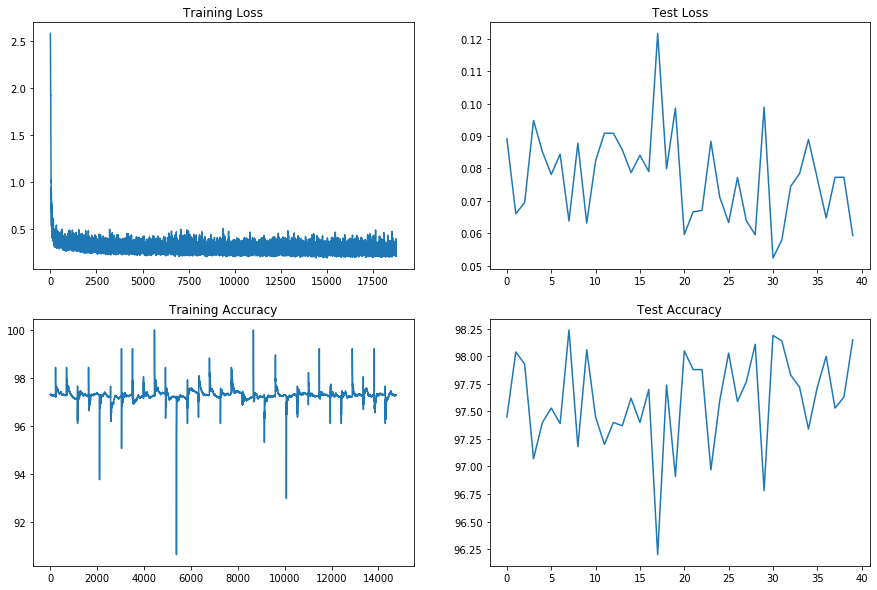

In [0]:
%matplotlib inline
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_acc[4000:])
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_acc)
axs[1, 1].set_title("Test Accuracy")

Submitted by G Uday Kiran and V Srilakshmi